<span style="font-size:200%; text-align:left;"><b>Lab setup of long SRC in a Michelson</b></span>
<br/>



# Importing packages

In [1]:
import pykat
import pykat.ifo as ifo
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
from pykat.optics import ABCD as a

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

import pickle
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset']=False


from scipy.optimize import minimize
from pykat.optics.gaussian_beams import BeamParam

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## The model

In [2]:
base = pykat.finesse.kat()
base.verbose = True
base.load("LongSRC_design_06Oct.kat")

base.removeBlock('Photodiodes')


## Run 0
Setting the phase of the BHD laser

--------------------------------------------------------------
Running kat - Started at 2019-10-11 16:34:05.754780

Finished in 0.0278921 seconds


100% | ETA:  0:00:00 | Saving data                                             

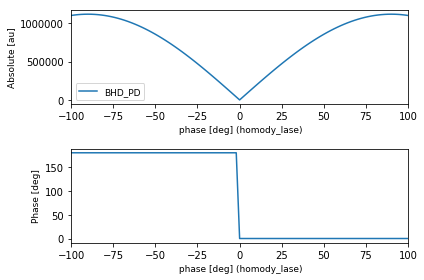

90.0


In [3]:
kat = base.deepcopy()
kat.cTSRM.remove()
kat.maxtem = 'off'

kat.parse("""
hd BHD_PD 180 nBDO2o nBDO5

fsig darm LX phase 1.0 0.0 
fsig darm LY phase 1.0 180.0 

xaxis homody_lase phase lin -100 100 100
yaxis abs:deg
""")

out = kat.run()

out.plot()
phs_value = out.x[out['BHD_PD'].argmax()]
#print(phs_value)
print(out.x[out['BHD_PD'].argmax()])

## SRC design

### Constraints and available RoCs

In [4]:
RoC = [0.05,0.15,0.2,0.4, 0.1,0.25,0.5,0.75,1,1.333,1.5,2,3,4,5,6.667,10]   # RoCs available off the shelf


w_crys = 30e-6

# Constraints
w_bs = 3.4e-3
w_etm = 4.8e-3
w_srm = 4.8e-3

# TSRC design


## Designing the TSRC length


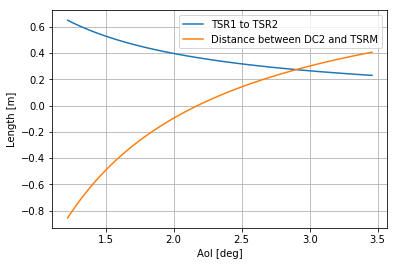

In [5]:
L_SRC = 1.21
# Safety margin between TSR1 and the optical axis between TSR2 and TSRM.
d = 0.015
# Radius of TSR1
a = 0.0127
# Safety margin between TSR1 and DC1 + safety margin between TSR2 and SRM. Quickly estimated values. 
b = 0.025 + 0.025
# Propagation through crystal
c = 1.8*0.01
# Distance of DCs from crystal
e = 0.04
# Transmission through SRM
f = 0.006*1.45

# Distance between telescope mirrors
L = np.linspace(0.23,0.65,100)
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L)*180.0/np.pi
# TSR path length (SRC with arms excluded)
L_DC2_TSRM = L_SRC - (L*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b + c + e + f)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta/2.0, L, label='TSR1 to TSR2')
# ax.plot(theta/2.0, L_tsr, label='TSRC minimum boptical path length')
ax.plot(theta/2.0, L_DC2_TSRM, label='Distance between DC2 and TSRM')

# ax.plot(theta/2.0, L_SRC-L_sr, label='Arm length')

#ax.plot([theta.min()/2.0, theta.max()/2.0],[L_SRC,L_SRC], 'r--', label='SRC length')

ax.grid()
ax.set_xlabel('AoI [deg]')
ax.set_ylabel('Length [m]')
ax.legend()
plt.show(fig)

In [6]:
L_tsr2 = 0.33
# 2*Angle of incidence on telescope mirrors
theta = np.arcsin((a+d)/L_tsr2)*180.0/np.pi
# TSR path length (SRC with arms excluded)
L_tsr1 = L_tsr2*np.cos(theta*np.pi/180.0) + 0.025
L_tsr3 = L_tsr2*np.cos(theta*np.pi/180.0) + 0.01
L_DC2_TSRM = L_SRC - (L_tsr2*(1.0+2.0*np.cos(theta*np.pi/180.0)) + b + c + e + f)
L_tsr2_crys = L_tsr3 + 2e-2 #2 cm is the distance from dichroic to crystal
L_Crys_TSRM = L_DC2_TSRM + 2e-2 #2 cm is the distance from dichroic to crystal

print('Angle of incidence: {} deg'.format(theta/2.0))
print('L_DC2_TSRM: {} m'.format(L_DC2_TSRM))
print('L_tsr1: {} m'.format(L_tsr1))
print('L_tsr3: {} m'.format(L_tsr3))
print('TSR2 to crystal: {} m'.format(L_tsr2_crys))
print('Crystal to TSR: {} m'.format(L_Crys_TSRM))


Angle of incidence: 2.4075193269558257 deg
L_DC2_TSRM: 0.10562923130186164 m
L_tsr1: 0.35383538434906914 m
L_tsr3: 0.3388353843490691 m
TSR2 to crystal: 0.35883538434906914 m
Crystal to TSR: 0.12562923130186163 m


## Maximum possible distance from TSR2 to DC1

In [7]:
from pykat.optics import ABCD as a

w0 = 30e-6
q0 = BeamParam(w0=w0, z=0, nr=kat.sCRYS.n.value)
S0 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)
S1 = a.mirror_trans(kat.sCRYS.n.value, 1, np.inf)
S3 = a.space(1,0.42)

Ssum1 = S3 * S1 * S0

q2 = a.apply(Ssum1, q0, 1.8, 1.0)

q2.w

0.004772997764312543

In [8]:
kat = base.deepcopy()
kat.cTSRM.remove()
kat.homody_lase.phase = phs_value

kat.ltsr1.L = 35.38e-2
kat.ltsr2.L = 33e-2
kat.TSR2_crys.L = (33.88 + 4.56)*1e-2
kat.lcrys_tsrm.L = 10e-2


kat.TSRM.Rc = 0.1

kat.parse("""

bp qex x q nEMx
bp qbsx x q nBS4
bp qsrm x q nSRM2
bp qtsr1 x q nTSR1a
bp qtsr2 x q nTSR2a
bp qcr1 x q nCRYS1a
bp q_cr1b x q nCRYS1b
bp qcr2 x q nCRYS2b
bp qtsrm x q nTSRM1


cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m

noxaxis
yaxis abs:deg
trace 10
""")

                
out = kat.run()


qex = out['qex']

qbsx = out['qbsx']
qsrm = out['qsrm']

qtsr1 = out['qtsr1']
qtsr2 = out['qtsr2']


qcr1 = out['qcr1']
qcr2 = out['qcr2']
qtsrm = out['qtsrm']



--------------------------------------------------------------
Running kat - Started at 2019-10-11 16:34:07.546283

Finished in 0.022069 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [9]:
## Optimising lengths and RoCs and checking for stabiltiy of TSRC

In [10]:
from scipy.optimize import minimize
from pykat.optics import ABCD as a

q0 = BeamParam(q=qsrm)
q1 = BeamParam(w0=30e-6, z=0, nr=1.8)


def stability_tsrc(rocs):
    roc1 = rocs[0]
    roc2 = rocs[1]
    
    # Outbound
    S1  = a.space(1.45, 0.006)
    S2  = a.mirror_trans(1.45, 1, np.inf)
    S3  = a.space(1,0.3538+dL-dL2)                   # L_TSR1
    S4  = a.mirror_refl(1,roc1)
    S5  = a.space(1, 0.33-dL)                    # L_TSR2
    S6  = a.mirror_refl(1,roc2)
    S7  = a.space(1.0, 0.3388+0.0456+dL2)         # L_TSR3 + DC-->Crystal
    S8  = a.mirror_trans(1.0, 1.8, np.inf) 
    S9  = a.space(1.8, 0.01)
    S10 = a.mirror_trans(1.8, 1.0, np.inf) 
    S11 = a.space(1.0, 0.0456 + 0.0544)       # Crystal-->DC + DC-->TSRM
    S12 = a.mirror_refl(1,0.1)
    
    # Inbound
    S13 = S11
    S14 = S8
    S15 = S9
    S16 = S10
    S17 = S7
    S18 = S6
    S19 = S5
    S20 = S4
    S21 = S3
    S22 = a.mirror_trans(1, 1.45, np.inf)
    S23 = S1
    S24 = a.mirror_refl(1.45, -2.0)

    
    M = S24*S23*S22*S21*S20*S19*S18*S17*S16*S15*S14*S13*S12*S11*S10*S9*S8*S7*S6*S5*S4*S3*S2*S1
    return (M[0,0] + M[1,1])/2.0


# Define mode overlap function between SRC and TSRC
def overlap(q_1, q_2):
    return 4.0*np.abs(q_1.imag * q_2.imag)/np.abs( q_1.q.conjugate() - q_2.q)**2
    

dL = 0
dL2= 0


def roc(roc1,roc2,q0):
    S0  = a.space(1,0.3538+dL-dL2)                   # L_TSR1
    S1  = a.mirror_refl(1,roc1)
    S2  = a.space(1, 0.33-dL)                    # L_TSR2
    S3  = a.mirror_refl(1,roc2)
    S4  = a.space(1.0, 0.3388+0.0456+dL2)         # L_TSR3 + DC-->Crystal
    S5  = a.mirror_trans(1.0, 1.8, np.inf) 
    S6  = a.space(1.8, 0.01/2.0)
    M = S6 * S5 * S4 * S3 * S2 * S1 * S0

    return a.apply(M, q0, 1, 1.8)


def fun(diopt1, diopt2):
    roc1 = 1.0/diopt1
    roc2 = 1.0/diopt2
    q = roc(roc1,roc2,q0)
    mm = overlap(q, q1)
    return 1.0-mm
    
def fun2(rocs):
    roc1 = 1.0/rocs[0]
    roc2 = 1.0/rocs[1]
    q = roc(roc1,roc2,q0)
    mm = overlap(q, q1)
    return 1.0-mm
    
   

sol1 = minimize(fun2, (1,1), method='Nelder-Mead',tol=None) #output returned in diopters. 
                                                            # The output currently returned currently is 
                                                            # optimal for the set lengths
rocs = 1.0/sol1.x
mm = sol1.fun
m = stability_tsrc(rocs)
g = (m+1.0)/2

In [11]:
def stability_tsrc(rocs):
    roc1 = rocs[0]
    roc2 = rocs[1]
    
    # Outbound
    S1  = a.space(1.45, 0.006)
    S2  = a.mirror_trans(1.45, 1, np.inf)
    S3  = a.space(1,kat.ltsr1.L.value + dL)
    S4  = a.mirror_refl(1,roc1)
    S5  = a.space(1, kat.ltsr2.L.value - dL)
    S6  = a.mirror_refl(1,roc2)
    S7  = a.space(1, kat.TSR2_crys.L) # Not allowed to be larger than 42 cm
    S8  = a.mirror_trans(1, kat.sCRYS.n.value, np.inf) 
    S9  = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value)
    S10  = a.mirror_trans(kat.sCRYS.n.value, 1, np.inf) 
    S11 = a.space(1,kat.lcrys_tsrm.L.value)
    S12 = a.mirror_refl(1,0.1)
    
    # Inbound
    S13 = S11
    S14 = S8
    S15 = S9
    S16 = S10
    S17 = S7
    S18 = S6
    S19 = S5
    S20 = S4
    S21 = S3
    S22 = a.mirror_trans(1, 1.45, np.inf)
    S23 = S1
    S24 = a.mirror_refl(1.45, -2.0)

    
    M = S24*S23*S22*S21*S20*S19*S18*S17*S16*S15*S14*S13*S12*S11*S10*S9*S8*S7*S6*S5*S4*S3*S2*S1
    return (M[0,0] + M[1,1])/2.0

stability_tsrc(rocs)

0.16844340575519687

In [12]:
rocs = 1.0/sol1.x
mm = sol1.fun
m = stability_tsrc(rocs)
g = (m+1.0)/2

In [13]:
print('Mismatch = {:.2e}'.format(mm))
print('RoC1 = {0[0]:.5f} m,  RoC2 = {0[1]:.5f} m'.format(rocs))
print('TSRC stability: m = {:.3f},  g = {:.3f}'.format(m,g))

Mismatch = 9.44e-12
RoC1 = -0.12682 m,  RoC2 = 0.38894 m
TSRC stability: m = 0.168,  g = 0.584


In [ ]:
dL = 0
diopts = 1.0/np.array([-0.12682, 0.38894])
fun2(diopts)

## Looping over various length changes

In [40]:
dL2 = 0.001
dLs = np.linspace(-0.1, 0.3, 101)
for dL in dLs:
    sol1 = minimize(fun2, (1,1), method='Nelder-Mead',tol=None) #output returned in diopters. 
                                                            # The output currently returned currently is 
                                                            # optimal for the set lengths
    rocs = 1.0/sol1.x
    mm = sol1.fun
    m = stability_tsrc(rocs)
    g = (m+1.0)/2
    print('dL = {:.4f}, dL2= {:.4f}, mismatch = {:.2e}'.format(dL,dL2, mm))
    print('RoC1 = {0[0]:.4f} m,  RoC2 = {0[1]:.4f} m'.format(rocs))
    print('TSRC stability: m = {:.3f},  g = {:.3f}'.format(m,g))
    print()

dL = -0.1000, dL2= 0.0010, mismatch = 1.06e-11
RoC1 = -0.1534 m,  RoC2 = 0.4381 m
TSRC stability: m = 0.569,  g = 0.784

dL = -0.0960, dL2= 0.0010, mismatch = 9.23e-11
RoC1 = -0.1524 m,  RoC2 = 0.4364 m
TSRC stability: m = 0.563,  g = 0.782

dL = -0.0920, dL2= 0.0010, mismatch = 3.45e-11
RoC1 = -0.1514 m,  RoC2 = 0.4347 m
TSRC stability: m = 0.558,  g = 0.779

dL = -0.0880, dL2= 0.0010, mismatch = 4.58e-11
RoC1 = -0.1504 m,  RoC2 = 0.4330 m
TSRC stability: m = 0.552,  g = 0.776

dL = -0.0840, dL2= 0.0010, mismatch = 2.35e-11
RoC1 = -0.1494 m,  RoC2 = 0.4312 m
TSRC stability: m = 0.546,  g = 0.773

dL = -0.0800, dL2= 0.0010, mismatch = 1.96e-11
RoC1 = -0.1483 m,  RoC2 = 0.4294 m
TSRC stability: m = 0.541,  g = 0.770

dL = -0.0760, dL2= 0.0010, mismatch = 2.21e-11
RoC1 = -0.1473 m,  RoC2 = 0.4276 m
TSRC stability: m = 0.535,  g = 0.768

dL = -0.0720, dL2= 0.0010, mismatch = 3.88e-11
RoC1 = -0.1463 m,  RoC2 = 0.4258 m
TSRC stability: m = 0.530,  g = 0.765

dL = -0.0680, dL2= 0.0010, misma

dL = 0.1760, dL2= 0.0010, mismatch = 5.25e-12
RoC1 = -0.0666 m,  RoC2 = 0.2520 m
TSRC stability: m = 0.217,  g = 0.609

dL = 0.1800, dL2= 0.0010, mismatch = 9.65e-12
RoC1 = -0.0650 m,  RoC2 = 0.2476 m
TSRC stability: m = 0.213,  g = 0.606

dL = 0.1840, dL2= 0.0010, mismatch = 1.18e-11
RoC1 = -0.0635 m,  RoC2 = 0.2432 m
TSRC stability: m = 0.208,  g = 0.604

dL = 0.1880, dL2= 0.0010, mismatch = 3.14e-12
RoC1 = -0.0619 m,  RoC2 = 0.2387 m
TSRC stability: m = 0.204,  g = 0.602

dL = 0.1920, dL2= 0.0010, mismatch = 4.52e-12
RoC1 = -0.0603 m,  RoC2 = 0.2341 m
TSRC stability: m = 0.199,  g = 0.600

dL = 0.1960, dL2= 0.0010, mismatch = 1.96e-12
RoC1 = -0.0587 m,  RoC2 = 0.2294 m
TSRC stability: m = 0.195,  g = 0.597

dL = 0.2000, dL2= 0.0010, mismatch = 1.40e-11
RoC1 = -0.0571 m,  RoC2 = 0.2246 m
TSRC stability: m = 0.191,  g = 0.595

dL = 0.2040, dL2= 0.0010, mismatch = 7.93e-12
RoC1 = -0.0555 m,  RoC2 = 0.2197 m
TSRC stability: m = 0.186,  g = 0.593

dL = 0.2080, dL2= 0.0010, mismatch = 1.4

### Choosing a possible set of RoCs

In [ ]:
# dL = -0.3200,  mismatch = 5.79e-11
# RoC1 = -0.2006 m,  RoC2 = 0.5094 m
# TSRC stability: m = 0.796,  g = 0.898


### Fine tuning that RoC

In [ ]:
# Chosen configuration
dL = -0.2817
diopts = 1.0/np.array([-0.200, 0.5])
fun2(diopts)

In [ ]:
dL = -0.2817  
diopts = 1.0/np.array([-0.200, 0.5])
fun2(diopts)

In [ ]:
dL2 = 0.0
dLs = np.linspace(-0.1, 0.1, 101)
for dL in dLs:
    sol1 = minimize(fun2, (1,1), method='Nelder-Mead',tol=None) #output returned in diopters. 
                                                            # The output currently returned currently is 
                                                            # optimal for the set lengths
    rocs = 1.0/sol1.x
    mm = sol1.fun
    m = stability_tsrc(rocs)
    g = (m+1.0)/2
    if ((m > -1 and m < 1)):
        print('dL = {:.4f}, dL2= {:.4f}, mismatch = {:.2e}'.format(dL,dL2, mm))
        print('RoC1 = {0[0]:.4f} m,  RoC2 = {0[1]:.4f} m'.format(rocs))
        print('TSRC stability: m = {:.3f},  g = {:.3f}'.format(m,g))

    else:
        print('Cavity is unstable!!!!! :(')
            
        

# Playground

In [ ]:
from scipy.optimize import minimize
from pykat.optics import ABCD as a

q0 = BeamParam(q=qsrm)
q1 = BeamParam(w0=30e-6, z=0, nr=1.8)


def stability_tsrc(rocs):
    roc1 = rocs[0]
    roc2 = rocs[1]
    
    # Outbound
    S1  = a.space(1.45, 0.006)
    S2  = a.mirror_trans(1.45, 1, np.inf)
    S3  = a.space(1,0.3538+dL-dL2)                   # L_TSR1
    S4  = a.mirror_refl(1,roc1)
    S5  = a.space(1, 0.33-dL)                    # L_TSR2
    S6  = a.mirror_refl(1,roc2)
    S7  = a.space(1.0, 0.3388+0.0456+dL2)         # L_TSR3 + DC-->Crystal
    S8  = a.mirror_trans(1.0, 1.8, np.inf) 
    S9  = a.space(1.8, 0.01)
    S10 = a.mirror_trans(1.8, 1.0, np.inf) 
    S11 = a.space(1.0, 0.0456 + 0.0544)       # Crystal-->DC + DC-->TSRM
    S12 = a.mirror_refl(1,0.1)
    
    # Inbound
    S13 = S11
    S14 = S8
    S15 = S9
    S16 = S10
    S17 = S7
    S18 = S6
    S19 = S5
    S20 = S4
    S21 = S3
    S22 = a.mirror_trans(1, 1.45, np.inf)
    S23 = S1
    S24 = a.mirror_refl(1.45, -2.0)

    
    M = S24*S23*S22*S21*S20*S19*S18*S17*S16*S15*S14*S13*S12*S11*S10*S9*S8*S7*S6*S5*S4*S3*S2*S1
    return (M[0,0] + M[1,1])/2.0


# Define mode overlap function between SRC and TSRC
def overlap(q_1, q_2):
    return 4.0*np.abs(q_1.imag * q_2.imag)/np.abs( q_1.q.conjugate() - q_2.q)**2
    

def roc(roc1,roc2,q0):
    S0  = a.space(1,0.3538+dL-dL2)                   # L_TSR1
    S1  = a.mirror_refl(1,roc1)
    S2  = a.space(1, 0.33-dL)                    # L_TSR2
    S3  = a.mirror_refl(1,roc2)
    S4  = a.space(1.0, 0.3388+0.0456+dL2)         # L_TSR3 + DC-->Crystal
    S5  = a.mirror_trans(1.0, 1.8, np.inf) 
    S6  = a.space(1.8, 0.01/2.0)
    M = S6 * S5 * S4 * S3 * S2 * S1 * S0

    return a.apply(M, q0, 1, 1.8)


def fun(diopt1, diopt2):
    roc1 = 1.0/diopt1
    roc2 = 1.0/diopt2
    q = roc(roc1,roc2,q0)
    mm = overlap(q, q1)
    return 1.0-mm
    
def fun2(rocs):
    roc1 = 1.0/rocs[0]
    roc2 = 1.0/rocs[1]
    q = roc(roc1,roc2,q0)
    mm = overlap(q, q1)
    return 1.0-mm
    
   
dL2 = 0.0
dLs = np.linspace(-0.3, 0.3, 101)
for dL in dLs:
    sol1 = minimize(fun2, (1,1), method='Nelder-Mead',tol=None) #output returned in diopters. 
                                                            # The output currently returned currently is 
                                                            # optimal for the set lengths
    rocs = 1.0/sol1.x
    mm = sol1.fun
    m = stability_tsrc(rocs)
    g = (m+1.0)/2
    print('dL = {:.4f}, dL2= {:.4f}, mismatch = {:.2e}'.format(dL,dL2, mm))
    print('RoC1 = {0[0]:.4f} m,  RoC2 = {0[1]:.4f} m'.format(rocs))
    print('TSRC stability: m = {:.3f},  g = {:.3f}'.format(m,g))
    print()

dL = -0.3200,  mismatch = 5.79e-11
RoC1 = -0.2006 m,  RoC2 = 0.5094 m
TSRC stability: m = 0.796,  g = 0.898

In [ ]:
RoC

In [ ]:
# Chosen configuration
dL = -0.2817
diopts = 1.0/np.array([-0.200, 0.5])
fun2(diopts)

In [ ]:
0.3538+dL


In [ ]:
0.33-dL

In [ ]:
0.3388+0.0456

In [ ]:
0.0456+0.0544

In [ ]:
(np.arctan(0.0277/(0.0721))*180.0/np.pi)

In [ ]:
(np.arctan(0.0277/(0.0721))*180.0/np.pi)/2

In [ ]:
# Chosen configuration
dL = 0.0240
diopts = 1.0/np.array([-0.1, 0.4])
fun2(diopts)